In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special
import math

In [2]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, hidden_layers, 
                 output_nodes,  learning_rate):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate
        self.node_params = [input_nodes]
        
        for i in range(hidden_layers):
            self.node_params.append(hidden_nodes)
        self.node_params.append(output_nodes)
                
        self.transition_count = hidden_layers + 1
        self.weights = []
        for i in range(self.transition_count):
            row, column = self.node_params[i + 1], self.node_params[i]
            self.weights.append(
                np.random.normal(0.0, pow(column, -0.5), (row, column))
            )
        self.activation_func = lambda x:scipy.special.expit(x)   
        self.epochs = []
        self.efficiency = []
        self.outputs = [None] * (self.transition_count + 1)
        self.errors = [None] * (self.transition_count + 1)
        
    def train_one_data_set(self, inputs_list, targets_list ):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        remarks = []
        
        self.outputs[0] = inputs # zero (pseudo) outputs is an input in NN
    
        for i in range(self.transition_count):
            self.outputs[i + 1] = self.activation_func(
                np.dot(self.weights[i], self.outputs[i])
            )
    
        self.errors[self.transition_count] = targets - self.outputs[self.transition_count]
        for i in reversed(range(self.transition_count)):
            self.errors[i] =  np.dot(self.weights[i].T, self.errors[i + 1])
        
        
        for i in reversed(range(self.transition_count)):
            remarks.insert(0, self.lr
                           * np.dot
                           (
                (self.errors[i + 1] * self.outputs[i + 1] * (1.0 - self.outputs[i + 1])),
                np.transpose(self.outputs[i])
                           )
            )
        
        return remarks
                    
                
    def train_one_batch(self, batch, targets):
        train_set_remarks = [] # каждый элемент - правка по каждому train set
        for i, one_train_dataset in enumerate(batch):
            vectored_target = np.zeros(self.onodes) + 0.01
            vectored_target[int(targets[i])] = 0.99
            one_data_set_remarks = self.train_one_data_set(one_train_dataset, vectored_target)
            train_set_remarks.append(one_data_set_remarks)
            
        # суммирование по каждому обучающему набору внутри батча
        summed_remarks = np.array(train_set_remarks, dtype=object).sum(axis=0) # like a tensor (batch_size, transition_count, (n,m)-error correction matrix) )
        
        for i, correct_weigths in enumerate(summed_remarks):
            self.weights[i] += correct_weigths
        
        
    def train(self, training_data_list, test_data_list, epochs, batch_size):
        self.epochs = []
        self.efficiency = []
        for e in range(epochs):
            batch_count = int(math.ceil(len(training_data_list) / batch_size))
            for i in range(batch_count):
                raw_batch = training_data_list[i*batch_size: (i+1)*batch_size]
                raw_batch = [record.split(',') for record in raw_batch]
                raw_batch = [[int(c) for c in record] for record in raw_batch]
                targets = [record[0] for record in raw_batch]
                batch = [record[1:] for record in raw_batch]
                batch = [(np.asfarray(values) / 255 * 0.99) + 0.01 for values in batch]
                self.train_one_batch(batch, targets)
    
            self.calc_efficiency(test_data_list)
            self.epochs.append(e)
            
    def calc_efficiency(self, test_data_list):
        scorecard = []
        for test_record in test_data_list:
            all_values = test_record.split(',')
            correct_label = int(all_values[0])
            inputs = (np.asfarray(all_values[1:]) / 255 * 0.99) + 0.01
            outputs = self.query(inputs)
            self_label = np.argmax(outputs)
            if correct_label == self_label:
                scorecard.append(1)
            else:
                scorecard.append(0)
        
        scorecard_array = np.array(scorecard)
        self.efficiency.append(scorecard_array.sum()/ scorecard_array.size)
    
    def query(self, inputs):
        outputs = inputs
        for i in range(self.transition_count):
            inputs = outputs
            outputs = self.activation_func(
                np.dot(self.weights[i], inputs)
            )            
        return outputs
        

In [4]:
input_nodes = 784
hidden_nodes = 300
output_nodes = 10
hidden_layers = 2
learning_rate = 0.1

nn = NeuralNetwork(input_nodes, hidden_nodes, hidden_layers,
                   output_nodes, learning_rate )
training_data_file = open('mnist_train.csv', 'r')
training_data_list = training_data_file.readlines()[:1_000]
training_data_file.close()

In [5]:
test_data_file = open('mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

nn.train(training_data_list, test_data_list, 10, 4)

max accuracy is 0.8882 at 9 epoch


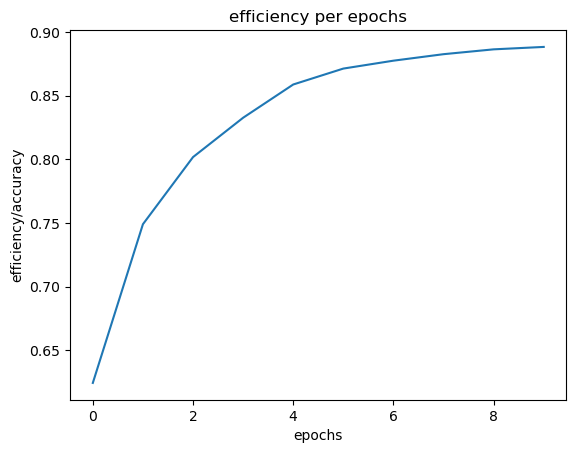

In [6]:
plt.title('efficiency per epochs')
plt.ylabel('efficiency/accuracy')
plt.xlabel('epochs')
plt.plot(nn.epochs, nn.efficiency)
maxima = np.argmax(np.array(nn.efficiency))
print(f'max accuracy is {nn.efficiency[maxima]} at {maxima} epoch' )